# EJERCICIO CLASE FINAL GRUPO 4

## INTEGRANTES:
- Carlos Chicaiza
- Emilio Mayorga
- Jessica Llumiguano
- Juan Vizuete

Se obtuvo los datos de un libro de Kaggle: https://www.kaggle.com/datasets/dnkumars/cybersecurity-intrusion-detection-dataset/data

Este conjunto de datos permite detectar intrusiones cibernéticas a partir del tráfico de red y el comportamiento del usuario. Contiene características clave para identificar amenazas y se puede utilizar en modelos de aprendizaje automático.

## Levantamiento de proyecto

Para iniciar con el levantamiento del proyecto, se tiene que primero instalar la libreria que permite conectarse entre python y postgresql que será la base de datos con la que trabajaremos.

In [2]:
%pip install psycopg2

Note: you may need to restart the kernel to use updated packages.


A continuación, se importan las librerías necesarias para el análisis de datos, visualización y conexión con la base de datos:  

- **pandas (`pd`)**: Con esta vamos a manejar y análisar los datos con un dataframe.  
- **numpy (`np`)**: No ayudara con el soporte para operaciones numéricas y trabajar con matrices.  
- **matplotlib.pyplot (`plt`)**: La usaremos par crear gráficos y visualizar datos.  
- **seaborn (`sns`)**: Esta libreria la usaremos con matplotlib para datos avanzados.  
- **psycopg2**: Con esta libreria podremos conectarnos y ejecutar consiltas en postgresql.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# base de datos
import psycopg2

### Carga del Conjunto de Datos  

Usamos `pandas` para cargar el archivo CSV en un **DataFrame**, lo que nos permite manipular y analizar los datos de manera eficiente.  

- `pd.read_csv(...)`: Carga el archivo CSV en un DataFrame de pandas.  
- `df`: Variable que almacena el DataFrame resultante.
- Despues de eso inspeccionamos los datos usando  `df.columns` para validar la cabecera, `df.shape` para conocer el tamaño del dataframe, y finalmente el `df.dtypes` para conocer los tipos de datos de cada columna.

In [5]:
df = pd.read_csv('./data/cybersecurity_intrusion_data.csv')

In [7]:
print(df.columns)

Index(['session_id', 'network_packet_size', 'protocol_type', 'login_attempts',
       'session_duration', 'encryption_used', 'ip_reputation_score',
       'failed_logins', 'browser_type', 'unusual_time_access',
       'attack_detected'],
      dtype='object')


In [8]:
print(df.shape)

(9537, 11)


In [6]:
print(df.dtypes)

session_id              object
network_packet_size      int64
protocol_type           object
login_attempts           int64
session_duration       float64
encryption_used         object
ip_reputation_score    float64
failed_logins            int64
browser_type            object
unusual_time_access      int64
attack_detected          int64
dtype: object


### Conexión con el servicio Postgres 

In [7]:
try:
    connection = psycopg2.connect(
        user="postgres", 
        password="postgres",
        host="localhost",
        port="5432"
    )
    connection.autocommit = True
    cursor = connection.cursor()
    cursor.execute("SELECT datname FROM pg_database WHERE datname='cybersecurity_intrusion';")
    if not cursor.fetchone():
        cursor.execute("CREATE DATABASE cybersecurity_intrusion;")
        print("Base creada")
    else:
        print("Si existe")
    
    cursor.close()  #Cerrada conexion al base
    connection.close() #Cerrada conexion al servidor
        
except Exception as e:
        print(f"Error al crear la base de datos: {e}")
    

Base creada


### Conexion con la base

In [8]:
try:
    connection = psycopg2.connect(
        database = "cybersecurity_intrusion",
        user="postgres", 
        password="postgres",
        host="localhost",
        port="5432"
    )
    cursor = connection.cursor()
    cursor.execute("SELECT table_name FROM information_schema.tables WHERE table_schema='public' and table_name='intrusion_log'  ;")
    if not cursor.fetchone():
        cursor.execute("""
            CREATE TABLE intrusion_log(
                       id SERIAL PRIMARY KEY,
                       session_id varchar(10),
                       network_packet_size int,
                       protocol_type varchar(5),
                       login_attempts int,
                       session_duration double precision,
                       encryption_used varchar(5),
                       ip_reputation_score double precision,
                       failed_logins int,
                       browser_type varchar(10),
                       unusual_time_access int,
                       attack_detected int
                       );
         """)
        print("Tabla creada")
    else:
        print("Si existe")
    
    connection.commit()

    cursor.close()  #Cerrada conexion al base
    connection.close() #Cerrada conexion al servidor
        
except Exception as e:
        print(f"Error al crear la tabla: {e}")
    

Tabla creada


## Preprocesamiento

In [3]:
print(df.isnull().sum())

session_id                0
network_packet_size       0
protocol_type             0
login_attempts            0
session_duration          0
encryption_used        1966
ip_reputation_score       0
failed_logins             0
browser_type              0
unusual_time_access       0
attack_detected           0
dtype: int64


Se convierte los campos de texto en minuscula

In [4]:
df_normalized = df.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
print(df_normalized[:5])

  session_id  network_packet_size protocol_type  login_attempts  \
0  sid_00001                  599           tcp               4   
1  sid_00002                  472           tcp               3   
2  sid_00003                  629           tcp               3   
3  sid_00004                  804           udp               4   
4  sid_00005                  453           tcp               5   

   session_duration encryption_used  ip_reputation_score  failed_logins  \
0        492.983263             des             0.606818              1   
1       1557.996461             des             0.301569              0   
2         75.044262             des             0.739164              2   
3        601.248835             des             0.123267              0   
4        532.540888             aes             0.054874              1   

  browser_type  unusual_time_access  attack_detected  
0         edge                    0                1  
1      firefox                    0 

Cambiar las celdas "Unknown" y "None" por "NaN"

In [5]:
df_normalized.replace(['unknown', None], np.nan, inplace=True)
print(df_normalized[10:20])

   session_id  network_packet_size protocol_type  login_attempts  \
10  sid_00011                  407           udp               6   
11  sid_00012                  406           udp               9   
12  sid_00013                  548           tcp               2   
13  sid_00014                  117           tcp               4   
14  sid_00015                  155           tcp               3   
15  sid_00016                  387          icmp               6   
16  sid_00017                  297           tcp               8   
17  sid_00018                  562           udp               1   
18  sid_00019                  318           tcp               5   
19  sid_00020                  217          icmp               2   

    session_duration encryption_used  ip_reputation_score  failed_logins  \
10        580.721925             des             0.122894              3   
11        191.052837             des             0.339711              1   
12        186.147638   

Se van a eliminar las filas con valores nulos

In [6]:
df_normalized.dropna(inplace=True)

In [13]:
print(df_normalized[0:10])

   session_id  network_packet_size protocol_type  login_attempts  \
0   sid_00001                  599           tcp               4   
1   sid_00002                  472           tcp               3   
2   sid_00003                  629           tcp               3   
4   sid_00005                  453           tcp               5   
5   sid_00006                  453           udp               5   
6   sid_00007                  815          icmp               4   
7   sid_00008                  653           tcp               3   
10  sid_00011                  407           udp               6   
11  sid_00012                  406           udp               9   
15  sid_00016                  387          icmp               6   

    session_duration encryption_used  ip_reputation_score  failed_logins  \
0         492.983263             des             0.606818              1   
1        1557.996461             des             0.301569              0   
2          75.044262   

Se ha limpiado la tabla.

### Iniciar guardado de datos

In [14]:
try:
    connection = psycopg2.connect(
        database = "cybersecurity_intrusion",
        user="postgres", 
        password="postgres",
        host="localhost",
        port="5432"
    )
    cursor = connection.cursor()
    
    logs = df_normalized[0:10]
    data_to_insert = [
    tuple(int(x) if isinstance(x, np.int64) else float(x) if isinstance(x, np.float64) else x for x in row)
    for row in logs[['session_id','network_packet_size','protocol_type','login_attempts','session_duration','encryption_used','ip_reputation_score','failed_logins','browser_type','unusual_time_access','attack_detected']].to_records(index=False)]   
    print(data_to_insert)
    cursor.executemany("""
        INSERT INTO intrusion_log (session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
        """,data_to_insert)

    connection.commit()
    print("Se han agregado los logs")
    cursor.close()  #Cerrada conexion al base
    connection.close() #Cerrada conexion al servidor
        
except Exception as e:
        print(f"Error al insertar los datos: {e}")
    

[('sid_00001', 599, 'tcp', 4, 492.9832634426563, 'des', 0.606818080396889, 1, 'edge', 0, 1), ('sid_00002', 472, 'tcp', 3, 1557.9964611204384, 'des', 0.3015689675960893, 0, 'firefox', 0, 0), ('sid_00003', 629, 'tcp', 3, 75.04426166420741, 'des', 0.7391643279163831, 2, 'chrome', 0, 1), ('sid_00005', 453, 'tcp', 5, 532.5408884201419, 'aes', 0.0548738567431703, 1, 'firefox', 0, 0), ('sid_00006', 453, 'udp', 5, 380.4715502453134, 'aes', 0.4224858607066699, 2, 'chrome', 1, 0), ('sid_00007', 815, 'icmp', 4, 728.1071646972356, 'aes', 0.4137719285892984, 1, 'chrome', 0, 1), ('sid_00008', 653, 'tcp', 3, 12.5999060098958, 'des', 0.0977193658576949, 3, 'chrome', 1, 1), ('sid_00011', 407, 'udp', 6, 580.7219253670751, 'des', 0.1228937389064628, 3, 'firefox', 0, 1), ('sid_00012', 406, 'udp', 9, 191.0528369326706, 'des', 0.3397112713433893, 1, 'edge', 0, 1), ('sid_00016', 387, 'icmp', 6, 292.1361960073892, 'des', 0.2549124511362793, 3, 'chrome', 0, 1)]
Se han agregado los logs


Se han añadido los logs.
Se procede a imprimir la tabla

In [15]:
try:
    connection = psycopg2.connect(
        database = "cybersecurity_intrusion",
        user="postgres", 
        password="postgres",
        host="localhost",
        port="5432"
    )
    cursor = connection.cursor()
    
    cursor.execute("SELECT * FROM intrusion_log LIMIT 10;")
    result = cursor.fetchall()
    
    for i in result:
        print(i)

    print("Se ha realizado la impresion")
    cursor.close()  #Cerrada conexion al base
    connection.close() #Cerrada conexion al servidor
        
except Exception as e:
        print(f"Error al insertar los datos: {e}")
    

(1, 'sid_00001', 599, 'tcp', 4, 492.9832634426563, 'des', 0.606818080396889, 1, 'edge', 0, 1)
(2, 'sid_00002', 472, 'tcp', 3, 1557.9964611204384, 'des', 0.3015689675960893, 0, 'firefox', 0, 0)
(3, 'sid_00003', 629, 'tcp', 3, 75.04426166420741, 'des', 0.7391643279163831, 2, 'chrome', 0, 1)
(4, 'sid_00005', 453, 'tcp', 5, 532.5408884201419, 'aes', 0.0548738567431703, 1, 'firefox', 0, 0)
(5, 'sid_00006', 453, 'udp', 5, 380.4715502453134, 'aes', 0.4224858607066699, 2, 'chrome', 1, 0)
(6, 'sid_00007', 815, 'icmp', 4, 728.1071646972356, 'aes', 0.4137719285892984, 1, 'chrome', 0, 1)
(7, 'sid_00008', 653, 'tcp', 3, 12.5999060098958, 'des', 0.0977193658576949, 3, 'chrome', 1, 1)
(8, 'sid_00011', 407, 'udp', 6, 580.7219253670751, 'des', 0.1228937389064628, 3, 'firefox', 0, 1)
(9, 'sid_00012', 406, 'udp', 9, 191.0528369326706, 'des', 0.3397112713433893, 1, 'edge', 0, 1)
(10, 'sid_00016', 387, 'icmp', 6, 292.1361960073892, 'des', 0.2549124511362793, 3, 'chrome', 0, 1)
Se ha realizado la impresion


## Gráficos

### Ataques recibidos por navegador

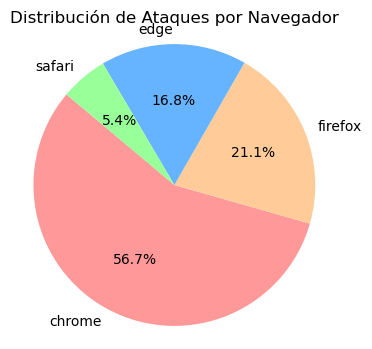

In [103]:
# Filtrar solo los ataques detectados (attack_detected == 1)
df_attacks = df_normalized[df_normalized['attack_detected'] == 1]

# Contar los ataques por tipo de navegador
attack_counts = df_attacks['browser_type'].value_counts()

# Crear el gráfico de pastel
plt.figure(figsize=(4, 4))
plt.pie(attack_counts, labels=attack_counts.index, autopct='%1.1f%%', startangle=140, 
        colors=['#ff9999','#ffcc99', '#66b3ff','#99ff99'])
plt.title('Distribución de Ataques por Navegador')
plt.axis('equal')  # Para hacer el gráfico circular

# Mostrar el gráfico
plt.savefig('img/distribution_attack_navegator.png')

### Gráfica de barras protocol_type y attack_detected

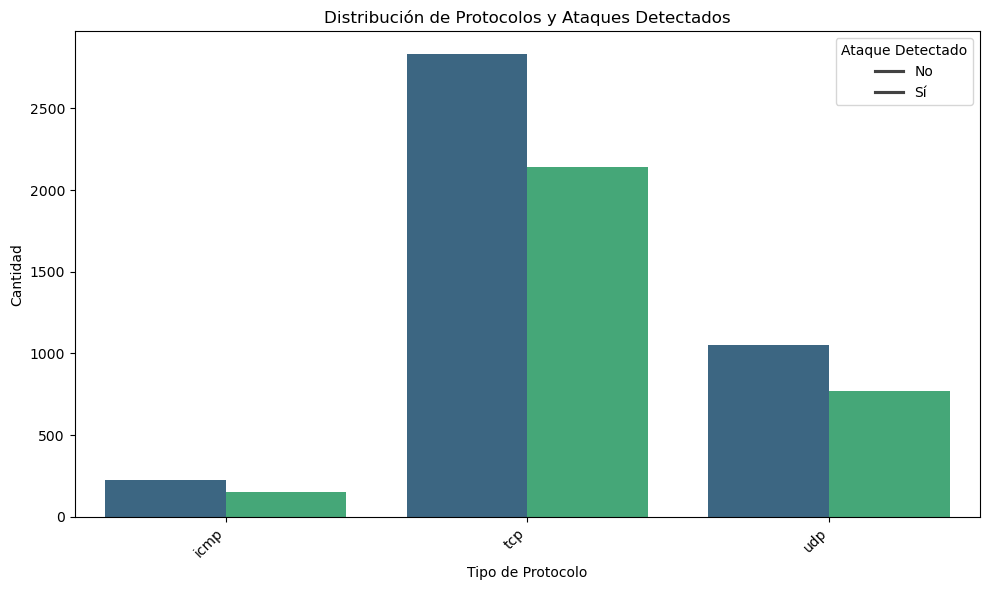

In [7]:
# Agrupar los datos por tipo de protocolo y ataque detectado
grouped_data = df_normalized.groupby(['protocol_type', 'attack_detected']).size().reset_index(name='count')

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data, x='protocol_type', y='count', hue='attack_detected', palette='viridis')

# Configurar el gráfico
plt.title('Distribución de Protocolos y Ataques Detectados')
plt.xlabel('Tipo de Protocolo')
plt.ylabel('Cantidad')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Ataque Detectado', labels=['No', 'Sí'])
plt.tight_layout()
plt.savefig('img/protocool_type_attack.png')

### Relación entre Duración de sesión y Puntuación de reputación de IP

In [24]:
df_normal_pic = df_normalized.copy() 
df_normal_pic['session_duration'] = df_normal_pic['session_duration'] / 60

El grafico representa la dispersión que existe entre la duración de las sesiones y la reputación de la ip, según cada uno de los protocolos usados.

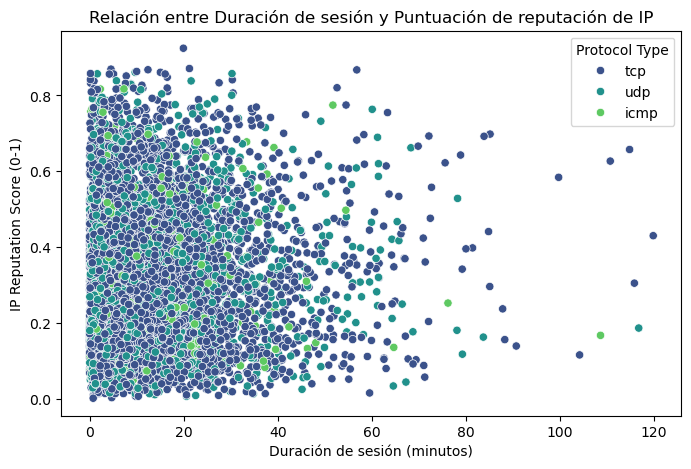

In [102]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_normal_pic, x="session_duration", y="ip_reputation_score", hue="protocol_type", palette="viridis")
plt.title("Relación entre Duración de sesión y Puntuación de reputación de IP")
plt.xlabel("Duración de sesión (minutos)")
plt.ylabel("IP Reputation Score (0-1)")
plt.legend(title="Protocol Type")
plt.savefig('img/duration_score_ip_protocol.png')

### Frecuencia de protocolos por navegador

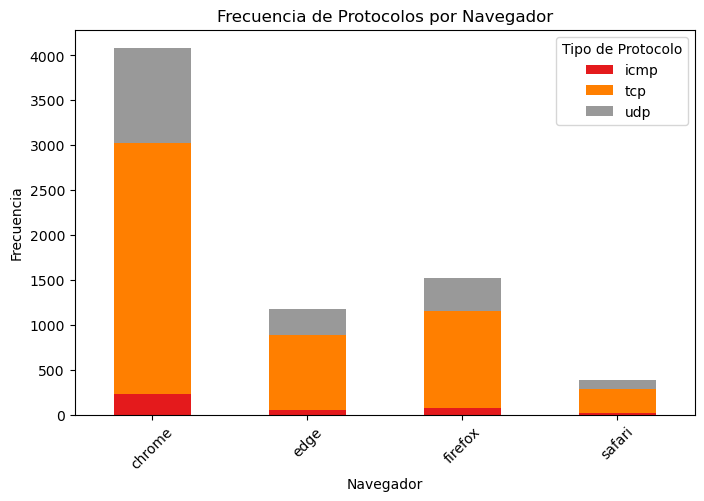

In [104]:
protocol_counts = pd.crosstab(df_normal_pic['browser_type'], df_normal_pic['protocol_type'])
protocol_counts.plot(kind='bar', stacked=True, figsize=(8, 5), colormap="Set1")
plt.title("Frecuencia de Protocolos por Navegador")
plt.xlabel("Navegador")
plt.ylabel("Frecuencia")
plt.legend(title="Tipo de Protocolo")
plt.xticks(rotation=45)
plt.savefig('img/protocol_frecuency_nav.png')

### Mapa de calor

Mapa de calor donde se calcula la correlación que existe en tre el tiempo de duración de la sesión, con los paquetes que se evian durante esa sesión y los ataques detectados en la misma

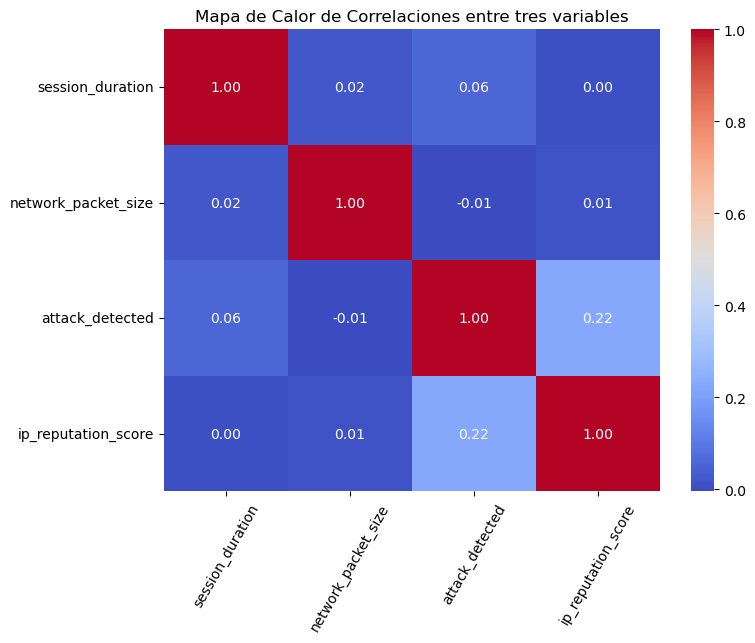

In [108]:
# Crear un DataFrame con las tres columnas que quieres analizar
df_three_vars = df_normalized[['session_duration', 'network_packet_size', 'attack_detected', 'ip_reputation_score']]

# Calcular la correlación entre las tres variables
correlation = df_three_vars.corr()

# Crear un mapa de calor (heatmap)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')

# Añadir título
plt.title('Mapa de Calor de Correlaciones entre tres variables')
plt.xticks(rotation=60)
# Mostrar el gráfico
plt.show()


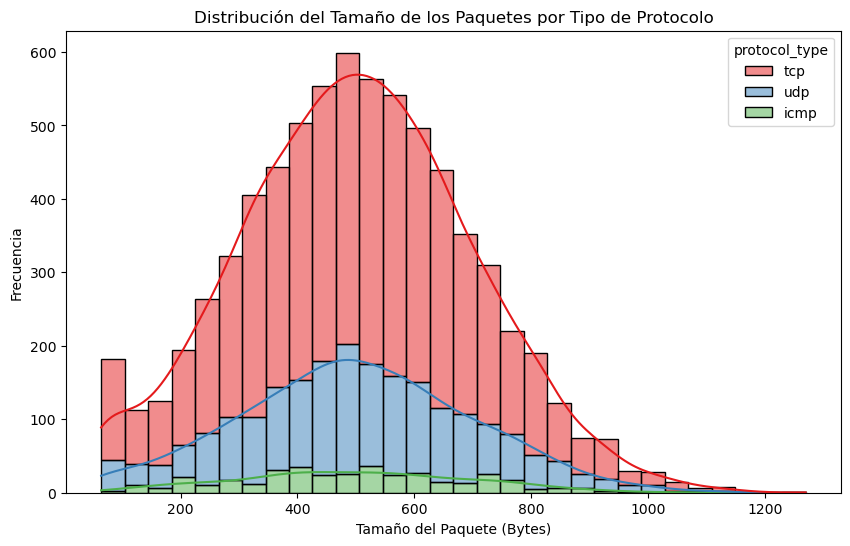

In [72]:
# Histograma del tamaño de los paquetes por tipo de protocolo
plt.figure(figsize=(10, 6))
sns.histplot(data=df_normal_pic, x="network_packet_size", hue="protocol_type", kde=True, multiple="stack", bins=30, palette="Set1")
plt.title('Distribución del Tamaño de los Paquetes por Tipo de Protocolo')
plt.xlabel('Tamaño del Paquete (Bytes)')
plt.ylabel('Frecuencia')
plt.show()